# Implementation of the Word2Vec Algorithm 1

#### Resources used: [Intuitive Guide to Understanding Word2Vec - by Thushan Ganegedara](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-word2vec-e0128a460f0f).

In [1]:
import collections
import math
import numpy as np
import os
import tensorflow as tf
from matplotlib import pylab
from sklearn.manifold import TSNE
import operator
from math import ceil

## Reading the Data

I have scraped the wikipedia page for 'France' and stored the text in a file called france.txt for use in this implementation.

In [2]:
def preprocess_text(text):
    """Clean the data to make it usable later"""
    text = text.lower()
    text = text.replace('.',' ')
    text = text.replace(',',' ')
    text = text.replace('-',' ')
    text = text.replace('%','')
    text = text.replace(':',' ')
    text = text.replace('(','')
    text = text.replace(')','')
    text = text.replace('\n',' ')
    text = text.replace('[',' ')
    text = text.replace(']',' ')
    text = text.replace('"',' ')
    text = text.replace('  ',' ')
    text = text.replace('   ',' ')
    text = text.replace('\n', ' ')
    return text

def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""

    with open(filename,'r') as f:
        data = []
        file_string = f.read()
        file_string = preprocess_text(file_string)
        file_string = file_string.split(' ')
        data.extend(file_string)
    return data
  
words = read_data('france.txt')
print('Data size %d' % len(words))
print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])

Data size 26458
Example words (start):  ['republic', 'in', 'europe', 'with', 'several', 'non', 'european', 'regions', 'french', 'republic']
Example words (end):  ['won', 'two', 'olympic', 'silver', 'medals', 'in', '2000', 'and', '1948', '']


In [3]:
vocabulary_size = 0
def build_dataset(words):
    global vocabulary_size
    
    # 'UNK' indicates an unknown word and can then be used as a token to show a missing word
    count = [['UNK', -1]]
    
    # Gets words sorted by frequency
    count.extend(collections.Counter(words).most_common())
    dictionary = dict()

    # For all words that appear >= 10 times in the dataset: Create an ID for each unique word and store it in the dictionary
    for word, c in count:
        if c<10:
            continue
        dictionary[word] = len(dictionary)
        vocabulary_size += 1

    data = list()
    unk_count = 0
    
    # Words that appear less than 10 times get classified as unknown, the others are classified based on their assigned ID
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  
            unk_count = unk_count + 1
        data.append(index)

    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:15])
print('Sample data', data[:15])
print('Vocabulary size:', vocabulary_size)

Most common words (+UNK) [['UNK', 10245], ('', 2022), ('the', 1996), ('of', 1005), ('and', 860), ('in', 732), ('france', 394), ('french', 346), ('to', 329), ('a', 306), ('as', 238), ('is', 233), ('by', 165), ('was', 151), ('with', 132)]
Sample data [47, 4, 38, 13, 92, 0, 34, 126, 6, 47, 0, 0, 77, 6, 0]
Vocabulary size: 327


## Generating the data

<img src="images/data_illustration.png" alt="Data" width="450"/>

In [4]:
data_index = 0

def generate_batch(batch_size, window_size):
    global data_index 
    
    # two numpy arras to hold target words (batch)
    # and context words (labels)
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # span defines the total window size
    span = 2 * window_size + 1 

    # The buffer holds the data contained within the span
    queue = collections.deque(maxlen=span)
    # Fill the buffer and update the data_index
    for _ in range(span):
        queue.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    for i in range(batch_size // (2*window_size)):
        k=0
        # Avoid the target word itself as a prediction
        for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
            batch[i * (2*window_size) + k] = queue[window_size]
            labels[i * (2*window_size) + k, 0] = queue[j]
            k += 1 
    
        # Everytime we read num_samples data points, update the queue
        queue.append(data[data_index])

        # If end is reached, circle back to the beginning
        data_index = (data_index + np.random.randint(window_size)) % len(data)
    return batch, labels


print('data:', [reverse_dictionary[di] for di in data[:8]])

data_index = 0
batch, labels = generate_batch(batch_size=8, window_size=2)
print('\nwith window_size = %d:' %2)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['republic', 'in', 'europe', 'with', 'several', '', 'european', 'regions']

with window_size = 2:
    batch: ['europe', 'europe', 'europe', 'europe', 'with', 'with', 'with', 'with']
    labels: ['republic', 'in', 'with', 'several', 'in', 'europe', 'several', '']


## Defining the Model

##### Hyperparameters

In [7]:
batch_size = 128  # Number of data points in we process at a given time
embedding_size = 64  # Size of a word vector
window_size = 4  # Size of the context window
num_sampled = 32  # Number of negative samples in the loss function

##### TensorFlow Placeholders

A placeholder is simply a variable that we will assign data to at a later date.

In [8]:
tf.reset_default_graph()

# Training input data (target word IDs). 
train_dataset = tf.placeholder(tf.int32, shape=[batch_size]) 

# Training input label data (context word IDs) 
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

##### Model Parameters

In [9]:
# Embedding layer
# tf.random_uniform: Outputs random values from a uniform distribution
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# Neural network weights and biases
softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=0.1 / math.sqrt(embedding_size)))

softmax_biases = tf.Variable(tf.random_uniform([vocabulary_size],-0.01,0.01))

##### Connecting the embedding layer to the neural network

The embedding layer **stores the word vectors of all the words found in the vocabulary**. As you can imaging this is an enormous matrix (of size [vocabulary size x embedding size]). 

This embedding size is a user-tunable parameter. The higher it is, the better performing your model will be. But we’ll not get much of a jaw-dropping performance/size gain, beyond a certain point (say, an embedding size of 500). This gigantic matrix is initialized randomly (just like a neural network) and is tweaked bit by bit, during the optimization process, to reveal the powerful word vectors.

<img src="images/embedding.png" alt="Embedding" width="450"/>

During the training, the neural network takes an **input word and attempt to predict the output word**. Then using a loss function, we **penalize the model for incorrect classifications and reward the model for correct classifications**. 

    1) For a given input word (the target word), find the corresponding word vector from the embedding layer
    2) Feed the word vector to the neural network, then try to predict the correct output word (a context word)
    3) By comparing the prediction and true context word, compute the loss
    4) Use the loss along with a stochastic optimizer to optimize the neural network and the embedding layer

The 'tf.nn.embedding_lookup' function takes our embedding layer as the input and a set of word IDs ('train_dataset') and outputs the corresponding word vectors to the variable 'embed'.

In [10]:
# Look up embeddings for a batch of inputs. 
embed = tf.nn.embedding_lookup(embeddings, train_dataset)

##### Sampled Softmax loss function

First, you compute the cross entropy loss between the true context word ID for a given target word and the prediction value corresponding to the true context word ID. Then to that, we add the cross entropy loss of K negative samples we sampled according to some noise distribution. On a high level, we define the loss as follows:
<img src="images/loss_function.png" alt="Embedding" width="600"/>

The takeaway message is that, the sampled softmax loss computes the loss by considering two types of entities:

    1) The index given by the true context word ID in the prediction vector (words within the context window)
    2) K indices that indicate word IDs, and are considered to be noise (words outside the context window)
    
<img src="images/loss_fc_vis.png" alt="Embedding" width="600"/>

In [14]:
loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(
    weights=softmax_weights, biases=softmax_biases, inputs=embed, 
    labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

##### Optimization

Optimize the loss with respect to the parameters of the embeddings layer and the neural network.

In [15]:
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

##### Evaluation

We get the normalized embedding layer by making the vector magnitude equal to 1.

In [16]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True)) 
normalized_embeddings = embeddings / norm

##### Overview

The following image recaps what the model does.
<img src="images/overview.png" alt="Embedding" width="450"/>

# Running the Skip-Gram Model

Our model is a Skip-Gram Model. The Skip-gram model architecture usually tries to achieve the reverse of what the CBOW model does. It tries to predict the source context words (surrounding words) given a target word (the center word).

In [18]:
num_steps = 250001 
session = tf.InteractiveSession() 
# Initialize the variables in the graph
tf.global_variables_initializer().run() 
print('Initialized') 
average_loss = 0

for step in range(num_steps): 
    # Generate a single batch of data
    batch_data, batch_labels = generate_batch( batch_size, window_size)
    
    # Optimize the embedding layer and neural network
    # compute loss
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)

    # Update the average loss variable
    average_loss += l

    if (step+1) % 5000 == 0:
        if step > 0:
            average_loss = average_loss / 5000

        print('Average loss at step %d: %f' % (step+1, average_loss))
        average_loss = 0

sg_embeddings = normalized_embeddings.eval()
session.close()

C:\Users\oktar\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 5000: 2.622299
Average loss at step 10000: 2.388238
Average loss at step 15000: 2.357825
Average loss at step 20000: 2.339013
Average loss at step 25000: 2.337385
Average loss at step 30000: 2.323112
Average loss at step 35000: 2.314060
Average loss at step 40000: 2.314074
Average loss at step 45000: 2.315782
Average loss at step 50000: 2.306744
Average loss at step 55000: 2.303023
Average loss at step 60000: 2.310873
Average loss at step 65000: 2.303650
Average loss at step 70000: 2.301426
Average loss at step 75000: 2.296468
Average loss at step 80000: 2.304329
Average loss at step 85000: 2.298980
Average loss at step 90000: 2.296444
Average loss at step 95000: 2.290715
Average loss at step 100000: 2.296656
Average loss at step 105000: 2.287728
Average loss at step 110000: 2.291626
Average loss at step 115000: 2.284665
Average loss at step 120000: 2.287025
Average loss at step 125000: 2.295669
Average loss at step 130000: 2.294267
Average loss at step

## Visualize Word Vectors

Here we visualize the word vectors by means of the t-SNE dimensionality reduction technique.

In [19]:
tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000)

# get the T-SNE manifold
two_d_embeddings = tsne.fit_transform(sg_embeddings)

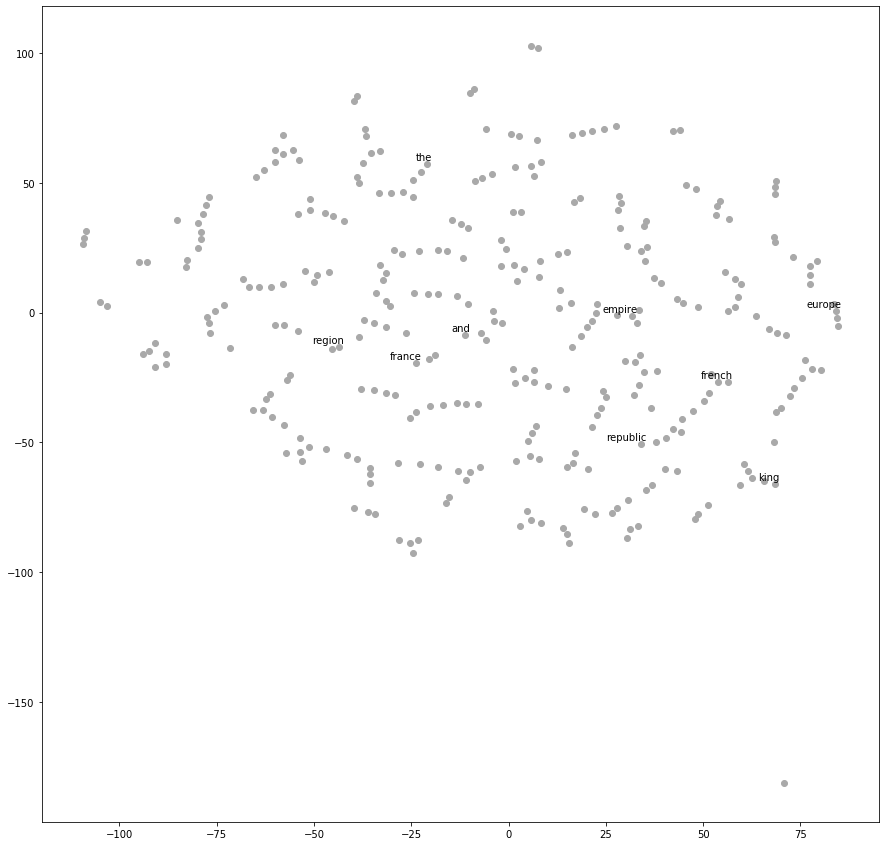

In [21]:
selected_words = ['france','republic','europe','the','region','and','french','army','king','empire','tourism']

words = [reverse_dictionary[i] for i in np.arange(vocabulary_size)]

pylab.figure(figsize=(15,15))
# plot all the embeddings and their corresponding words
for i, label in enumerate(words):
    x, y = two_d_embeddings[i,:]
    pylab.scatter(x, y, c='darkgray')   
    if label in selected_words:
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom',fontsize=10)
        
pylab.show()